# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Problem Defination
In this project, we will start by exploring the data frames then clean them and merge them into one data frame to do some visualizations and create a model to predict the event type based on demographic data and other information.

# Data Exploration

#### portfolio

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

#### profile

In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.shape

(17000, 5)

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


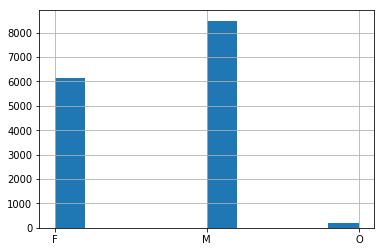

In [12]:
profile.gender.hist();

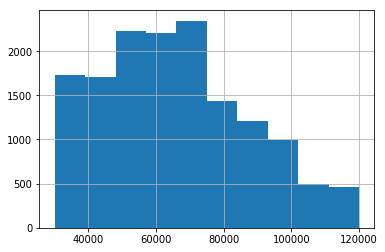

In [13]:
profile.income.hist();

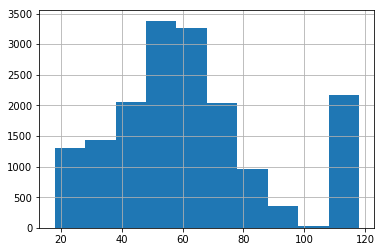

In [14]:
profile.age.hist();

In [15]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

#### transcript

In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript.shape

(306534, 4)

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [21]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

# Data Cleaning

#### portfolio 

In [22]:
#create dummy varibles of the 'channels' column at 'portfloio' 
dummy_df = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)

# Drop the original column
portfolio.drop('channels', inplace=True, axis=1)

# concatenate the dummy df with 'portfolio' df 
portfolio = pd.concat([portfolio, dummy_df], axis=1)


In [23]:
portfolio = portfolio.rename(columns={'id':'offer_id'})

In [24]:
portfolio.head(10)

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


#### profile 

In [25]:
# Drop null values at 'profile' 
profile.dropna(inplace=True)
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [26]:
# change type of 'became_member_on' column to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [27]:
profile = profile.rename(columns={'id':'customer_id'})

In [28]:
profile.head()

,age,became_member_on,gender,customer_id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


#### transcript

In [29]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [30]:
def clean_transcript():
    """
    This fuction will clean the transcript by extracting values 
    from the 'value' column into new columns
    
    
    Parameters:
    None
    
    Returns:
    None
    """
    index = 0;
    transcript['offer_id'] = ""
    transcript['reward'] = ""
    transcript['is_transection'] = ""
    transcript['amount'] = ""
    
    for val in transcript['value']:
        print('index no.{} is currently being processed'.format(index))
        transcript.iloc[index,4] = list(val.values())[0] if list(val.keys())[0] in ['offer id','offer_id'] else None
        try:
            transcript.iloc[index,5] = list(val.values())[1] if list(val.keys())[1] == 'reward' else None
        except: 
            transcript.iloc[index,5] = None
        transcript.iloc[index,6] = 0 if list(val.keys())[0] in ['offer id','offer_id'] else 1
        transcript.iloc[index,7] = list(val.values())[0] if list(val.keys())[0] == 'amount' else None
        index = index + 1
    del transcript['value']


In [31]:
clean_transcript()

In [32]:
new_transcript = transcript
new_transcript.to_csv('new_transcript.csv')

In [33]:
new_transcript = pd.read_csv('new_transcript.csv')
new_transcript.drop('Unnamed: 0', axis = 1, inplace=True)

In [34]:
new_transcript.head()

,event,person,time,offer_id,reward,is_transection,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,NaN


In [35]:
new_transcript['event'] = new_transcript['event'].str.replace(' ', '-')


In [36]:
#create dummy varibles of the 'channels' column at 'portfloio' 
dummy_event_df = pd.get_dummies(new_transcript['event'])


# concatenate the dummy df with 'portfolio' df 
new_transcript = pd.concat([new_transcript, dummy_event_df], axis=1)



In [37]:
new_transcript = new_transcript.rename(columns={'person':'customer_id'})


### Final Cleaning

In [38]:
def id_mapper(df, old_column_name, new_column_name):
    """
    This fuction will map every id to a unique integer number
    
    
    Parameters:
    df (dataframe): the dataframe contains  the column
    old_column_name (String): the original name of the column before proccessing
    new_column_name (String): the name of the new id column that will be generated
    is_portfolio (Boolean): to save the dict to use it later on profile df
    is_profile (Boolean): to use dict created for mapping each offer id to same id at portfolio
    
    Returns:
    None
    """
    coded_dict = dict()  
    counter = 1
    encoded_ids = []
    
    for val in df[old_column_name]:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter+=1
        
        encoded_ids.append(coded_dict[val])
    del df[old_column_name]
    df[new_column_name] = encoded_ids




In [39]:
new_df = pd.merge(new_transcript, profile, on='customer_id')

In [40]:
new_df = pd.merge(new_df, portfolio, on='offer_id')

In [41]:
new_df.head()

,event,customer_id,time,offer_id,reward_x,is_transection,amount,offer-completed,offer-received,offer-viewed,...,gender,income,difficulty,duration,offer_type,reward_y,email,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,NaN,0,1,0,...,F,100000.0,5,7,bogo,5,1,1,0,1
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,NaN,0,0,1,...,F,100000.0,5,7,bogo,5,1,1,0,1
2,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0,NaN,1,0,0,...,F,100000.0,5,7,bogo,5,1,1,0,1
3,offer-received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,NaN,0,1,0,...,M,70000.0,5,7,bogo,5,1,1,0,1
4,offer-viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,NaN,0,0,1,...,M,70000.0,5,7,bogo,5,1,1,0,1


In [42]:
new_df.columns

Index(['event', 'customer_id', 'time', 'offer_id', 'reward_x',
       'is_transection', 'amount', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'age', 'became_member_on', 'gender',
       'income', 'difficulty', 'duration', 'offer_type', 'reward_y', 'email',
       'mobile', 'social', 'web'],
      dtype='object')

In [43]:
id_mapper(new_df, 'offer_id', 'offer_id')
id_mapper(new_df, 'customer_id', 'customer_id')


In [44]:
new_df.head()

,event,time,reward_x,is_transection,amount,offer-completed,offer-received,offer-viewed,transaction,age,...,difficulty,duration,offer_type,reward_y,email,mobile,social,web,offer_id,customer_id
0,offer-received,0,NaN,0,NaN,0,1,0,0,75,...,5,7,bogo,5,1,1,0,1,1,1
1,offer-viewed,6,NaN,0,NaN,0,0,1,0,75,...,5,7,bogo,5,1,1,0,1,1,1
2,offer-completed,132,5.0,0,NaN,1,0,0,0,75,...,5,7,bogo,5,1,1,0,1,1,1
3,offer-received,408,NaN,0,NaN,0,1,0,0,68,...,5,7,bogo,5,1,1,0,1,1,2
4,offer-viewed,420,NaN,0,NaN,0,0,1,0,68,...,5,7,bogo,5,1,1,0,1,1,2


In [45]:
new_df.to_csv('new_df.csv')
new_df = pd.read_csv('new_df.csv')

# Visualizations

In [46]:
new_df['age'].min(),new_df['age'].max()

(18, 101)

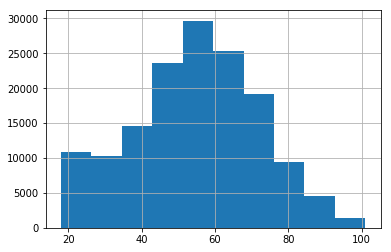

In [47]:
new_df['age'].hist();

Most of the users are Middle-aged

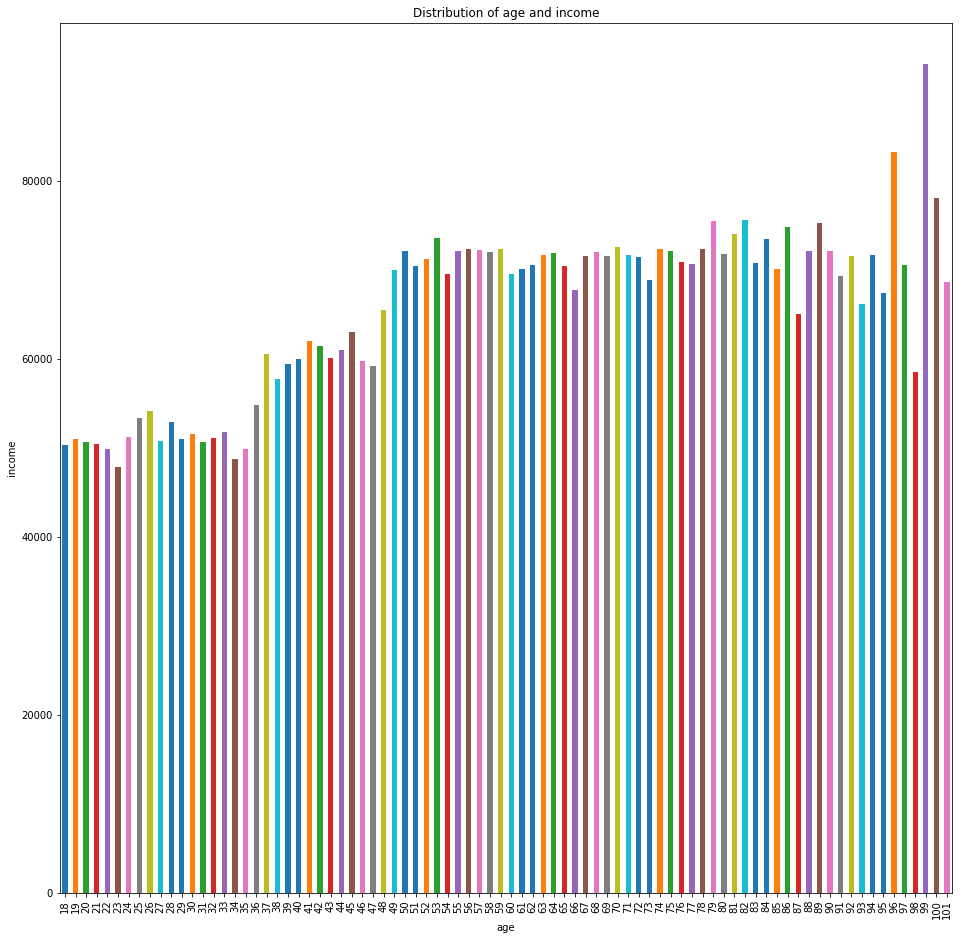

In [48]:
age_income = new_df.groupby('age')['income'].mean()
age_income.plot(kind='bar', title='Distribution of age and income', figsize=(16,16))
plt.xlabel('age')
plt.ylabel('income');

The income of the users keep increasing until they reach almost 50 years old the it is slightly changing

In [49]:
new_df['offer_type'].value_counts()

bogo             63834
discount         62311
informational    22660
Name: offer_type, dtype: int64

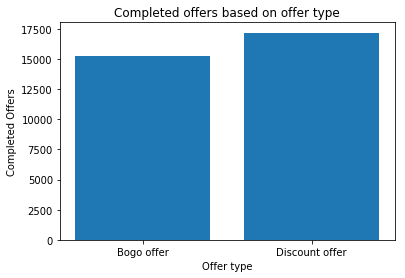

In [50]:
x1 = new_df[(new_df['offer-completed'] == 1) & (new_df['offer_type'] == 'bogo')].shape[0]
x2 = new_df[(new_df['offer-completed'] == 1) & (new_df['offer_type'] == 'discount')].shape[0]
labels = ['Bogo offer', 'Discount offer']
plt.bar([1,2], [x1,x2], tick_label = labels)
plt.title('Completed offers based on offer type')
plt.xlabel('Offer type')
plt.ylabel('Completed Offers');

Discount offers are a little bit more likely to be completed by a user

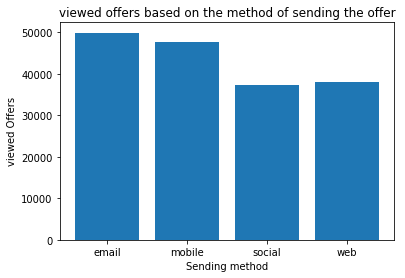

In [51]:
x1 = new_df[(new_df['offer-viewed'] == 1) & (new_df['email'] == 1)].shape[0]
x2 = new_df[(new_df['offer-viewed'] == 1) & (new_df['mobile'] == 1)].shape[0]
x3 = new_df[(new_df['offer-viewed'] == 1) & (new_df['social'] == 1)].shape[0]
x4 = new_df[(new_df['offer-viewed'] == 1) & (new_df['web'] == 1)].shape[0]
labels = ['email', 'mobile', 'social', 'web']
plt.bar([1,2,3,4], [x1,x2,x3,x4], tick_label = labels)
plt.title('viewed offers based on the method of sending the offer')
plt.xlabel('Sending method')
plt.ylabel('viewed Offers');

'email' sending method's offers are most likely to be completed than other methods

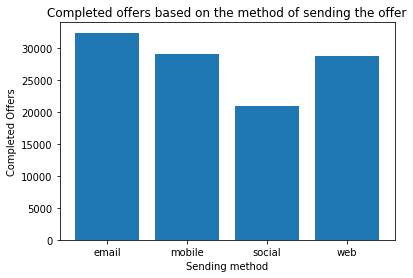

In [52]:
x1 = new_df[(new_df['offer-completed'] == 1) & (new_df['email'] == 1)].shape[0]
x2 = new_df[(new_df['offer-completed'] == 1) & (new_df['mobile'] == 1)].shape[0]
x3 = new_df[(new_df['offer-completed'] == 1) & (new_df['social'] == 1)].shape[0]
x4 = new_df[(new_df['offer-completed'] == 1) & (new_df['web'] == 1)].shape[0]
labels = ['email', 'mobile', 'social', 'web']
plt.bar([1,2,3,4], [x1,x2,x3,x4], tick_label = labels)
plt.title('Completed offers based on the method of sending the offer')
plt.xlabel('Sending method')
plt.ylabel('Completed Offers');

'email' sending method's offers are most likely to be completed than other methods

In [53]:
new_df['duration'].value_counts()

7     62535
5     33221
10    30389
3     12516
4     10144
Name: duration, dtype: int64

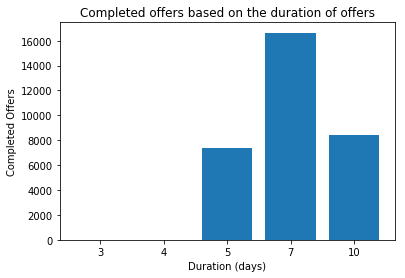

In [54]:
x1 = new_df[(new_df['offer-completed'] == 1) & (new_df['duration'] == 3)].shape[0]
x2 = new_df[(new_df['offer-completed'] == 1) & (new_df['duration'] == 4)].shape[0]
x3 = new_df[(new_df['offer-completed'] == 1) & (new_df['duration'] == 5)].shape[0]
x4 = new_df[(new_df['offer-completed'] == 1) & (new_df['duration'] == 7)].shape[0]
x5 = new_df[(new_df['offer-completed'] == 1) & (new_df['duration'] == 10)].shape[0]
labels = ['3', '4', '5', '7', '10']
plt.bar([1,2,3,4,5], [x1,x2,x3,x4,x5], tick_label = labels)
plt.title('Completed offers based on the duration of offers')
plt.xlabel('Duration (days)')
plt.ylabel('Completed Offers');

offers with 7-days duration ary likely to be completed

# Modeling

In [55]:
new_df['gender'].value_counts()

M    82896
F    63719
O     2190
Name: gender, dtype: int64

In [56]:
new_df['offer_type'].value_counts()

bogo             63834
discount         62311
informational    22660
Name: offer_type, dtype: int64

In [57]:
new_df.head()

,Unnamed: 0,event,time,reward_x,is_transection,amount,offer-completed,offer-received,offer-viewed,transaction,...,difficulty,duration,offer_type,reward_y,email,mobile,social,web,offer_id,customer_id
0,0,offer-received,0,NaN,0,NaN,0,1,0,0,...,5,7,bogo,5,1,1,0,1,1,1
1,1,offer-viewed,6,NaN,0,NaN,0,0,1,0,...,5,7,bogo,5,1,1,0,1,1,1
2,2,offer-completed,132,5.0,0,NaN,1,0,0,0,...,5,7,bogo,5,1,1,0,1,1,1
3,3,offer-received,408,NaN,0,NaN,0,1,0,0,...,5,7,bogo,5,1,1,0,1,1,2
4,4,offer-viewed,420,NaN,0,NaN,0,0,1,0,...,5,7,bogo,5,1,1,0,1,1,2


In [58]:
new_df['gender'] = new_df['gender'].map({'M': 1, 'F': 2, 'O': 3})
new_df['offer_type'] = new_df['offer_type'].map({'bogo': 1, 'discount': 2, 'informational': 3})
new_df['event_id'] = new_df['event'].map({'offer-completed': 1, 'offer-received': 2, 'offer-viewed': 3})


In [59]:
new_df.fillna(0, inplace=True)

In [60]:
new_df.head()

,Unnamed: 0,event,time,reward_x,is_transection,amount,offer-completed,offer-received,offer-viewed,transaction,...,duration,offer_type,reward_y,email,mobile,social,web,offer_id,customer_id,event_id
0,0,offer-received,0,0.0,0,0.0,0,1,0,0,...,7,1,5,1,1,0,1,1,1,2
1,1,offer-viewed,6,0.0,0,0.0,0,0,1,0,...,7,1,5,1,1,0,1,1,1,3
2,2,offer-completed,132,5.0,0,0.0,1,0,0,0,...,7,1,5,1,1,0,1,1,1,1
3,3,offer-received,408,0.0,0,0.0,0,1,0,0,...,7,1,5,1,1,0,1,1,2,2
4,4,offer-viewed,420,0.0,0,0.0,0,0,1,0,...,7,1,5,1,1,0,1,1,2,3


#### using RandomForestClassifier

In [61]:
X = new_df.drop(['event','reward_x','is_transection','offer-completed', 'offer-received', 'offer-viewed',
                'transaction', 'became_member_on', 'reward_y', 'offer_id', 'customer_id','event_id'], axis = 1)
y = new_df['event_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predicted_train = clf.predict(X_train)
predicted_test = clf.predict(X_test)

score_of_train = accuracy_score(y_train, predicted_train)
score_of_test = accuracy_score(y_test, predicted_test)

print('Accuracy Of Training: ' , score_of_train)
print('Accuracy Of Testing: ', score_of_test)

Accuracy Of Training:  0.971717404453
Accuracy Of Testing:  0.532704627929


In [62]:
parameters = {
    'n_estimators': [10, 25],
    'min_samples_split' : [2,4],
    'oob_score':[True, False]
 }

cv = GridSearchCV(RandomForestClassifier(), param_grid=parameters, n_jobs=-1)
cv.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 25], 'min_samples_split': [2, 4], 'oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
cv.best_params_

{'min_samples_split': 4, 'n_estimators': 25, 'oob_score': False}

In [64]:
X = new_df.drop(['event','reward_x','is_transection','offer-completed', 'offer-received', 'offer-viewed',
                'transaction', 'became_member_on', 'reward_y', 'offer_id', 'customer_id','event_id'], axis = 1)
y = new_df['event_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier(min_samples_split= 4, n_estimators=25, oob_score= False)
clf.fit(X_train, y_train)

predicted_train = clf.predict(X_train)
predicted_test = clf.predict(X_test)

score_of_train = accuracy_score(y_train, predicted_train)
score_of_test = accuracy_score(y_test, predicted_test)

print('Accuracy Of Training: ' , score_of_train)
print('Accuracy Of Testing: ', score_of_test)

Accuracy Of Training:  0.936906579112
Accuracy Of Testing:  0.531069396532


### using DecisionTreeClassifier

In [70]:
X = new_df.drop(['event','reward_x','is_transection','offer-completed', 'offer-received', 'offer-viewed',
                'transaction', 'became_member_on', 'reward_y', 'offer_id', 'customer_id','event_id'], axis = 1)
y = new_df['event_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

predicted_train = clf.predict(X_train)
predicted_test = clf.predict(X_test)

score_of_train = accuracy_score(y_train, predicted_train)
score_of_test = accuracy_score(y_test, predicted_test)

print('Accuracy Of Training: ' , score_of_train)
print('Accuracy Of Testing: ', score_of_test)

Accuracy Of Training:  1.0
Accuracy Of Testing:  0.600197123785


#### optimizing the model

In [71]:
parameters = {
    'min_samples_leaf': [1, 2],
    'min_samples_split' : [2,4],
    'presort':[True, False]
 }

cv = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters, n_jobs=-1)
cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 2], 'min_samples_split': [2, 4], 'presort': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
cv.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 4, 'presort': False}

In [73]:
X = new_df.drop(['event','reward_x','is_transection','offer-completed', 'offer-received', 'offer-viewed',
                'transaction', 'became_member_on', 'reward_y', 'offer_id', 'customer_id','event_id'], axis = 1)
y = new_df['event_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = DecisionTreeClassifier(min_samples_leaf= 2, min_samples_split= 2, presort= False)
clf.fit(X_train, y_train)

predicted_train = clf.predict(X_train)
predicted_test = clf.predict(X_test)

score_of_train = accuracy_score(y_train, predicted_train)
score_of_test = accuracy_score(y_test, predicted_test)

print('Accuracy Of Training: ' , score_of_train)
print('Accuracy Of Testing: ', score_of_test)

Accuracy Of Training:  0.900041281453
Accuracy Of Testing:  0.627615250213


## Conclusion
The two models are not accurate enough to depend on, the most challenging part for me was cleaning the data frames.


In [69]:
!tar chvfz notebook.tar.gz *

DSND-Capstone-Project/
DSND-Capstone-Project/README.md
DSND-Capstone-Project/.git/
DSND-Capstone-Project/.git/config
DSND-Capstone-Project/.git/hooks/
DSND-Capstone-Project/.git/hooks/pre-commit.sample
DSND-Capstone-Project/.git/hooks/applypatch-msg.sample
DSND-Capstone-Project/.git/hooks/update.sample
DSND-Capstone-Project/.git/hooks/pre-rebase.sample
DSND-Capstone-Project/.git/hooks/pre-applypatch.sample
DSND-Capstone-Project/.git/hooks/pre-push.sample
DSND-Capstone-Project/.git/hooks/post-update.sample
DSND-Capstone-Project/.git/hooks/commit-msg.sample
DSND-Capstone-Project/.git/hooks/prepare-commit-msg.sample
DSND-Capstone-Project/.git/branches/
DSND-Capstone-Project/.git/packed-refs
DSND-Capstone-Project/.git/index
DSND-Capstone-Project/.git/description
DSND-Capstone-Project/.git/refs/
DSND-Capstone-Project/.git/refs/tags/
DSND-Capstone-Project/.git/refs/remotes/
DSND-Capstone-Project/.git/refs/remotes/origin/
DSND-Capstone-Project/.git/refs/remotes/origin/HEAD
DSND-Capstone-Proje